# Load Data

In [10]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict
from liftpose.preprocess import center_poses
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# declare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/fly_prism/data_oriented/',#mac/ubuntu path
             #'data_dir'       : r"\Users\NeLy\Desktop\fly_prism/data_oriented/training_data", #windows path  
             'out_dir'        : '/data/LiftPose3D/fly_prism/data_oriented/',
             "train_subjects" : ["001","002","003"],
             'test_subjects'  : ["004"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'])

# center poses
train = center_poses(train, par_data['data']['roots'])
test = center_poses(test, par_data['data']['roots'])

#project data to ventral view
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)
train_keypts = Z_coord_dict(train_keypts)
test_keypts = Z_coord_dict(test_keypts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [11]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'])

[main.py:190]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_prism/data_oriented/stat_2d.pth.tar.
[main.py:209]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_prism/data_oriented/stat_3d.pth.tar.
[main.py:237]:INFO:Starting training model.
[main.py:248]:DEBUG:
==================Options=================
[main.py:249]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_prism/data_oriented',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_prism/data_oriented',
    'out_dir': '/data/LiftPose3D/fly_prism/data_oriented',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:250]:DEBUG:==========================================

[lift.py:44]:INFO:Training on t

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.60645|: 100%|██████████| 161/161 [00:01<00:00, 144.79it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.26059 | Loss Train  0.33927|: 100%|██████████| 161/161 [00:01<00:00, 146.00it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.26110 | Loss Train  0.22599|: 100%|██████████| 161/161 [00:01<00:00, 144.15it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.17385 | Loss Train  0.16280|: 100%|██████████| 161/161 [00:01<00:00, 145.02it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.13503 | Loss Train  0.12976|: 100%|██████████| 161/161 [00:01<00:00, 147.08it/s]
Epoch 005 | LR  0.00100 | Loss Test  0.13707 | Loss Train  0.11231|: 100%|██████████| 161/161 [00:01<00:00, 147.05it/s]
Epoch 006 | LR  0.00100 | Loss Test  0.14490 | Loss Train  0.10343|: 100%|██████████| 161/161 [00:01<00:00, 143.67it/s]
Epoch 007 | LR  0.00100 | Loss Test  0.11897 | Loss Train  0.09516|: 100%|██████████| 161/161 [00:01<00:00, 135.71it/s]
Epoch 008 | LR  0.00100 | Loss Test  0.1

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


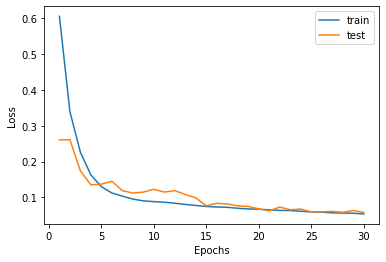

In [12]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)
#plt.savefig('loss.svg')

# Run Trained LiftPose3D Network on the Test Data

In [13]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:334]:INFO:starting testing in path: /data/LiftPose3D/fly_prism/data_oriented/
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.28M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/fly_prism/data_oriented/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 30 | err: 0.05815011154202854)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/fly_prism/data_oriented/test_results.pth.tar


# Visualize Predictions

In [14]:
from liftpose.postprocess import load_test_results
test_3d_gt, test_3d_pred, good_keypts = load_test_results(par['out_dir'], prism=True)
test_3d_gt *= 2.5/400
test_3d_pred *= 2.5/400

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


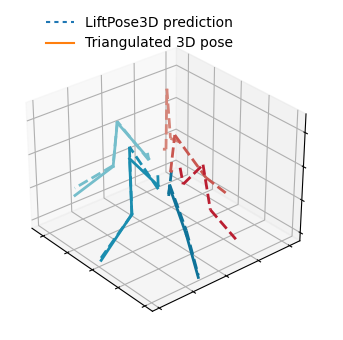

In [15]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=140)

t = 1000
plot_pose_3d(ax, 
             bones=par_data["vis"]["bones"], 
             pred=test_3d_pred[t],
             tar=test_3d_gt[t],
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"],
             good_keypts=good_keypts[t][:,None],
             show_pred_always=True,
             legend=True)

# Video

[animation.py:329]:DEBUG:frame size in pixels is 1200 x 1200
[animation.py:345]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1200 -pix_fmt rgba -r 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -y LP3D_prediction.mp4
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWrit

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

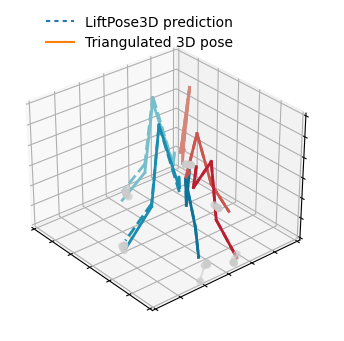

In [16]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=140)

ax.set_xlim([-1,2])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-0.4,0.2])
    
plot_video_3d(fig, ax, n=500, par=par_data, tar=test_3d_gt, pred=test_3d_pred, trailing=10, trailing_keypts=[4,9,14,19,24,29], fps=10)

# Errors

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved


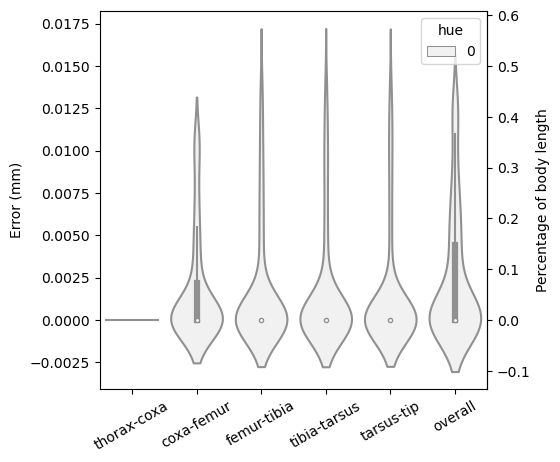

In [26]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(5,5), dpi=100)
names = ['thorax-coxa','coxa-femur','femur-tibia','tibia-tarsus','tarsus-tip']
ax = plt.gca()
s = test_3d_gt.shape
test_3d_gt_reshape = test_3d_gt.reshape(s[0]*6, s[1]//6, 3)
test_3d_pred_reshape = test_3d_pred.reshape(s[0]*6, s[1]//6, 3)
violin_plot(ax, gt=test_3d_gt_reshape, pred=test_3d_pred_reshape, good_keypts=np.ones_like(test_3d_gt_reshape),
                name=names, order=names, units='mm', body_length=3)

In [ ]:
import cv2
def video_to_imgs(vid_path):
    '''Convert video to a list of images'''
    
    cap = cv2.VideoCapture(vid_path)         
    imgs = []            
    while True:
        flag, frame = cap.read()
        if flag:                            
            imgs.append(frame)       
        else:
            break        
    
    return imgs

imgs = video_to_imgs('output.mp4')
for i, im in enumerate(imgs):
    if i<10:
        cv2.imwrite('00' + str(i) + '.png', im)
    elif i<100:
        cv2.imwrite('0' + str(i) + '.png', im)
    else:
        cv2.imwrite(str(i) + '.png', im)

In [ ]:
#ffmpeg -i DLC_prediction.mp4 -i LP3D_prediction.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output.mp4
#ffmpeg -f image2 -i %*.png -pix_fmt yuv420p  out.mp4
#ffmpeg -i out.mp4 -filter:v "setpts=5.0*PTS" video_2.mp4